In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import requests
import os

In [2]:
training_df = pd.read_csv("Training_data.csv").drop("Unnamed: 0",axis=1)
training_df.head()

,File,Review,Label
0,2893_10.txt,Walt Disney's CINDERELLA takes a story everybo...,1
1,7944_9.txt,"Have you ever, or do you have, a pet who's bee...",1
2,11725_10.txt,"I suck at gratuitous Boob references, so i'm j...",1
3,1587_10.txt,"Does anyone know, where I can see or download ...",1
4,10297_8.txt,Well not actually. This movie is very entertai...,1


In [3]:
words = (
    training_df.Review.
    str.lower().
    str.replace("[^\w\s]","").
    str.split()
)
bag_of_words = words.apply(Counter)

In [4]:
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

In [5]:
url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt"
r = requests.get(url)
s=';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n; \n; Opinion Lexicon: Positive\n;\n; This file contains a list of POSITIVE opinion words (or sentiment words).\n;\n; This file and the papers can all be downloaded from \n;    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html\n;\n; If you use this list, please cite one of the following two papers:\n;\n;   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." \n;       Proceedings of the ACM SIGKDD International Conference on Knowledge \n;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, \n;       Washington, USA, \n;   Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing \n;       and Comparing Opinions on the Web." Proceedings of the 14th \n;       International World Wide Web conference (WWW-2005), May 10-14, \n;       2005, Chiba, Japan.\n;\n; Notes: \n;    1. The appearance of an opinion word in a sentence does not necessarily  \n;       mean that the sentence expresses a positive or negative opinion. \n;       See the paper below:\n;\n;       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in \n;          Handbook of Natural Language Processing, Second Edition, \n;          (editors: N. Indurkhya and F. J. Damerau), 2010.\n;\n;    2. You will notice many misspelled words in the list. They are not \n;       mistakes. They are included as these misspelled words appear \n;       frequently in social media content. \n;\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'
pos_words = r.text[len(s)+2:]
pos_words = pos_words.split("\n")

In [6]:
url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt"
r = requests.get(url)
s=';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n; \n; Opinion Lexicon: Negative\n;\n; This file contains a list of NEGATIVE opinion words (or sentiment words).\n;\n; This file and the papers can all be downloaded from \n;    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html\n;\n; If you use this list, please cite one of the following two papers:\n;\n;   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." \n;       Proceedings of the ACM SIGKDD International Conference on Knowledge \n;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, \n;       Washington, USA, \n;   Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing \n;       and Comparing Opinions on the Web." Proceedings of the 14th \n;       International World Wide Web conference (WWW-2005), May 10-14, \n;       2005, Chiba, Japan.\n;\n; Notes: \n;    1. The appearance of an opinion word in a sentence does not necessarily  \n;       mean that the sentence expresses a positive or negative opinion. \n;       See the paper below:\n;\n;       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in \n;          Handbook of Natural Language Processing, Second Edition, \n;          (editors: N. Indurkhya and F. J. Damerau), 2010.\n;\n;    2. You will notice many misspelled words in the list. They are not \n;       mistakes. They are included as these misspelled words appear \n;       frequently in social media content. \n;\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n\n'
neg_words = r.text[len(s):]
neg_words = neg_words.split("\n")

In [7]:
reviews = []
for r in words:
    good = []
    for w in r:
        if w not in en_stops:
            good.append(w)
    reviews.append(good)
reviews = pd.Series(reviews)

In [8]:
pos_set = set(pos_words)
neg_set = set(neg_words)
posc = []
negc = []
for r in reviews:
    count_pos = len(pos_set.intersection(set(r)))
    count_neg = len(neg_set.intersection(set(r)))
    posc.append(count_pos)
    negc.append(count_neg)
    

In [9]:
y_train = training_df.Label
X_train = pd.DataFrame({"Positive_counts":posc, "Negative_counts":negc, "ones":[1]*len(y_train)})
X_train

,Positive_counts,Negative_counts,ones
0,23,6,1
1,13,3,1
2,8,3,1
3,2,2,1
4,7,1,1
...,...,...,...
24995,3,3,1
24996,2,13,1
24997,12,9,1
24998,3,9,1


In [10]:
#pd.DataFrame(list(reviews.apply(Counter)))

In [11]:
import matplotlib.pyplot as plt

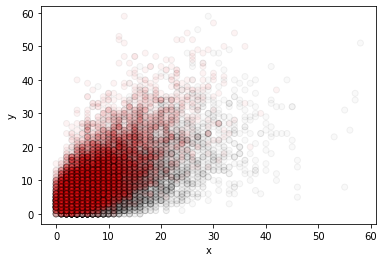

In [12]:
plt.scatter(X_train.Positive_counts, X_train.Negative_counts, c=y_train, cmap=plt.cm.Set1,
            edgecolor='k',alpha=0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Building the Soft-SVM

In [20]:
def gradient_comp(X,y,C,w0):
    summands_of_X = X[X.dot(w0) * y <= 1]
    summands_of_y = y[summands_of_X.index]
    Y = []
    for i in range(summands_of_X.shape[1]):
        Y.append(list(summands_of_y))
    summands = -1*np.multiply(pd.DataFrame(Y).values.T,summands_of_X)
    gradient = w0 + C*summands.sum()
    return gradient

In [21]:
def soft_SVM_training(X,y,C,w0,eps,lr,n):
    # X is training data
    # y is labels
    # C is penalty of how hard to be
    # w is initial weights vector (np.array)
    # eps is convergence criterion
    # lr is learning rate
    
    # Computing gradient of L
    i = 0
    gradw = gradient_comp(X,y,C,w0)
    w1 = w0 - lr*gradw
    while(np.linalg.norm(w0-w1) > eps):
        w0 = w1
        w1 = w0 - lr*gradient_comp(X,y,C,w0)
        i = i + 1
        print(i)
        if i == n:
            break
    return w1
        
    

In [24]:
weight = soft_SVM_training(X_train,
                  y_train,
                  1,
                  np.array([X_train.Positive_counts.mean(),X_train.Negative_counts.mean(),1]),
                  10^-3,
                  0.05,
                  100)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [25]:
def plot_data_with_classifier(X,y,w):
    # plot points
    plt.clf()
    plt.scatter(X.loc[:, "Positive_counts"], X.loc[:, "Negative_counts"], c=y, cmap=plt.cm.Set1, edgecolor='k')

    # draw hyperplane
    xrange = np.linspace(np.min(X.loc[:, "Positive_counts"]),X.loc[:, "Negative_counts"])
    yrange = -(w[0]*xrange+w[2])/w[1]
    plt.plot(xrange,yrange,'red')

    plt.show()

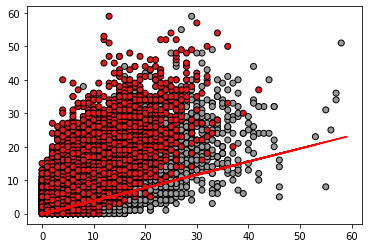

In [26]:
plot_data_with_classifier(X_train,y_train,weight)

In [28]:
weight

Positive_counts    2748.570190
Negative_counts   -7028.110945
ones               -718.402739
dtype: float64

# -------------------------------------------------------------------------------------------

In [8]:
pos_set = set(pos_words)
neg_set = set(neg_words)
sentiment_words = []
for r in reviews:
    positives = list(pos_set.intersection(set(r)))
    negatives = list(neg_set.intersection(set(r)))
    sentiment_words.append(positives+negatives)
sentiment_words = pd.Series(sentiment_words)

In [9]:
tf = pd.DataFrame(list(sentiment_words.apply(Counter)))
tf = tf.fillna(0)
tf

,thrilling,captivating,like,remarkably,formidable,charm,appealing,aspirations,beautifully,lovely,...,harridan,lapsed,irresolute,untested,hatefulness,impetuously,undamaged,ambitiously,inflammatory,diabolic
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
docFreq = (tf > 0).sum(axis=0)
idf = np.log(len(tf) / docFreq)
tf_idf = tf*idf

In [11]:
tf_idf

,thrilling,captivating,like,remarkably,formidable,charm,appealing,aspirations,beautifully,lovely,...,harridan,lapsed,irresolute,untested,hatefulness,impetuously,undamaged,ambitiously,inflammatory,diabolic
0,5.143024,5.390433,0.78176,5.541664,6.725434,4.240527,4.793912,6.830794,4.127695,4.191737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.78176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.78176,0.000000,0.000000,4.240527,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.78176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.000000,0.000000,0.78176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.793912,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.000000,0.000000,0.78176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_train = tf_idf
X_train["ones"] = [1]*len(tf_idf)
y_train = training_df.Label

In [23]:
weight = soft_SVM_training(X_train,
                  y_train,
                  1,
                  np.array([0]*X_train.shape[1]),
                  10^-3,
                  0.01,
                  100)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [24]:
np.save("tf_idf_model.npy",weight)

In [29]:
tf_idf_model = np.load("tf_idf_model.npy")

TESTING

In [43]:
all_words = X_train.columns

In [44]:
test_df = pd.read_csv("Test_data.csv").drop("Unnamed: 0",axis=1)
test_df.head()

,File,Review,Label
0,2893_10.txt,"""Rush in Rio"" is, no doubt, one of the most ex...",1
1,8705_10.txt,I have seen a number of horror movies to know ...,1
2,11725_10.txt,I'm a fan of B grade 80s films in which the he...,1
3,9859_8.txt,"I think that Pierre Léaud, or his character, t...",1
4,12409_10.txt,This picture doesn't have any big explosions o...,1


In [45]:
words = (
    test_df.Review.
    str.lower().
    str.replace("[^\w\s]","").
    str.split()
)
bag_of_words = words.apply(Counter)

In [46]:
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

In [47]:
url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt"
r = requests.get(url)
s=';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n; \n; Opinion Lexicon: Positive\n;\n; This file contains a list of POSITIVE opinion words (or sentiment words).\n;\n; This file and the papers can all be downloaded from \n;    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html\n;\n; If you use this list, please cite one of the following two papers:\n;\n;   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." \n;       Proceedings of the ACM SIGKDD International Conference on Knowledge \n;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, \n;       Washington, USA, \n;   Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing \n;       and Comparing Opinions on the Web." Proceedings of the 14th \n;       International World Wide Web conference (WWW-2005), May 10-14, \n;       2005, Chiba, Japan.\n;\n; Notes: \n;    1. The appearance of an opinion word in a sentence does not necessarily  \n;       mean that the sentence expresses a positive or negative opinion. \n;       See the paper below:\n;\n;       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in \n;          Handbook of Natural Language Processing, Second Edition, \n;          (editors: N. Indurkhya and F. J. Damerau), 2010.\n;\n;    2. You will notice many misspelled words in the list. They are not \n;       mistakes. They are included as these misspelled words appear \n;       frequently in social media content. \n;\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;'
pos_words = r.text[len(s)+2:]
pos_words = pos_words.split("\n")

In [48]:
url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt"
r = requests.get(url)
s=';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n; \n; Opinion Lexicon: Negative\n;\n; This file contains a list of NEGATIVE opinion words (or sentiment words).\n;\n; This file and the papers can all be downloaded from \n;    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html\n;\n; If you use this list, please cite one of the following two papers:\n;\n;   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." \n;       Proceedings of the ACM SIGKDD International Conference on Knowledge \n;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, \n;       Washington, USA, \n;   Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing \n;       and Comparing Opinions on the Web." Proceedings of the 14th \n;       International World Wide Web conference (WWW-2005), May 10-14, \n;       2005, Chiba, Japan.\n;\n; Notes: \n;    1. The appearance of an opinion word in a sentence does not necessarily  \n;       mean that the sentence expresses a positive or negative opinion. \n;       See the paper below:\n;\n;       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in \n;          Handbook of Natural Language Processing, Second Edition, \n;          (editors: N. Indurkhya and F. J. Damerau), 2010.\n;\n;    2. You will notice many misspelled words in the list. They are not \n;       mistakes. They are included as these misspelled words appear \n;       frequently in social media content. \n;\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n\n'
neg_words = r.text[len(s):]
neg_words = neg_words.split("\n")

In [49]:
reviews = []
for r in words:
    good = []
    for w in r:
        if w not in en_stops:
            good.append(w)
    reviews.append(good)
reviews = pd.Series(reviews)

In [50]:
sents = set(all_words)
sentiment_words = []
for r in reviews:
    sentiment_words.append(list(sents.intersection(set(r))))
sentiment_words = pd.Series(sentiment_words)

In [51]:
tf = pd.DataFrame(list(sentiment_words.apply(Counter)))
tf = tf.fillna(0)
tf

,great,like,flawless,fans,enjoyable,isolated,good,frenzy,talent,drunken,...,choleric,draconian,congested,doubtfully,effigy,divisiveness,preeminent,crueler,cheerless,clog
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
docFreq = (tf > 0).sum(axis=0)
idf = np.log(len(tf) / docFreq)
tf_idf = tf*idf

In [53]:
tf_idf

,great,like,flawless,fans,enjoyable,isolated,good,frenzy,talent,drunken,...,choleric,draconian,congested,doubtfully,effigy,divisiveness,preeminent,crueler,cheerless,clog
0,1.396264,0.795667,5.501658,3.120842,3.539081,5.355946,1.010821,7.035589,3.362746,5.541664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010821,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.396264,0.000000,0.000000,0.000000,0.000000,0.000000,1.010821,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010821,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010821,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.000000,0.795667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_test = tf_idf
X_test["ones"] = [1]*len(tf_idf)
y_test = test_df.Label